# HW 3 - Blood Drive Simulation

* Nicholas Y. Abroo
* AAP - Summer24

In this notebook, we will be exploring and simulating the process of donating blood. I picked this type of simulation because I've donated blood before and wanted to simulate how the wait times would be based on the number of people who where working at each station. 

## Preliminaries

In [10]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

In [87]:
import math
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
from IPython.display import Image
import simpy

In [89]:
%matplotlib inline

## NOTE
This jupyter notebook will consist of some basic modeling for the blood drive simulation and will guide the user to understand the process of the model. Please refer to the python file named 'blood_drive_simulation_file.py' to run, execute, and look at the code.

# Model

Here is the basic model of what the blood donation would look like.

    Arrival --> Fill in Registration/Questionare Form --> Nurse conducts Medical Screening/Mini Physical --> Draw Blood --> Head to grab a refreshment/snack --> Exit

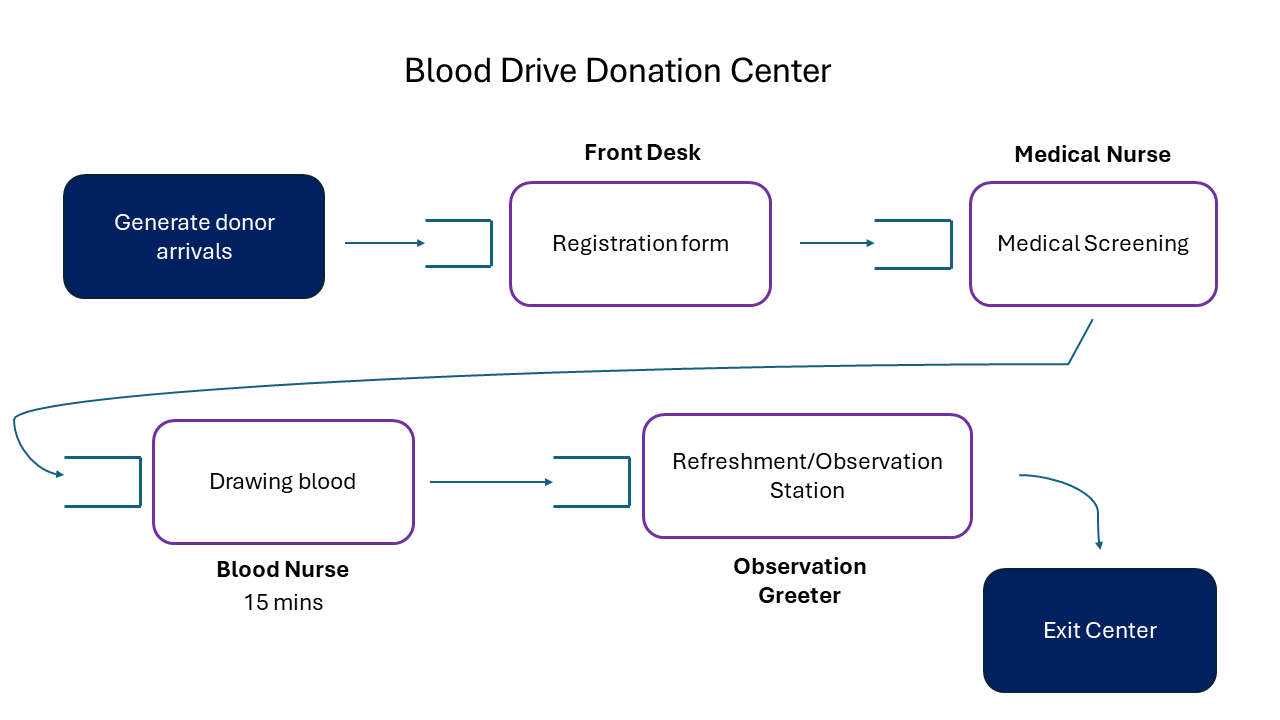

In [78]:
Image("screenshots/model_image.png")

I decided to set up this model with the focus of having the user input various parameters to see what it might take to staff a correct amount of workers to create as little of a wait time as possible. Blood Drives have very high turnouts, so wait times are expected, but with the correct amount of workers in the simulation may help decrease that wait time to be bearable. So obvioulsy, it's not very realistic to have just one medical nurse or two blood nurses to handle those stations. So when you do try this simulation, put a realistic number as this scenario is a very labor intensive model that requires multiple people. 

Here is a simple explaination/steps of how this Donation Center would work:
1. Donors enter the center
2. Donors will ask for a registration form to which they have to fill out some basic information (Name, Address, Height, Weight, etc.) and any other health related questions.
3. Next, a donor will sit with a medical nurse to review and ask/answer and questions that is needed, as well as performing preliminary clinical task, such as checking heartrate, blood pressure, tempature check, etc.
4. Once approved, the Donor will go to an avalaible bed where a Blood nurse will setup and insert devices to draw blood. This step in the model takes the longest at a constant rate of 15 minutes.
5. Finally the Donor's last step will recieve refreshaments since they have just drawn 0.5 L of blood. Many Donors may feel light headed and can utilize this station for observation.
6. The donor leaves the center. 

## Blood Donation Center Class

In steps 2 through 5, are specific parameters that give random intervals of how long it may take for someone to complete this step.
```python
    def complete_registration(self, donor):
        yield self.env.timeout(random.randint(5, 8))

    def medical_screening(self, donor):
        yield self.env.timeout(random.randint(5, 10))

    def drawing_blood(self, donor):
        yield self.env.timeout(15)

    def wait_time_post_blood(self, donor):
        yield self.env.timeout(random.randint(1, 6))
```

As you can see above, the various steps have a random interval of what it may take for the donor to complete that step. For example, it may take anywhere between five to eight minutes to complete the registration form and turn it in to the front desk workers. One thing to note, the drawing of the blood is a constant time of only 15 minutes to draw blood, it can't take a small amount of time to complete this, so that is why that is a constant number. 

## Arriving at the Center

The arrive_blood_drive function demonstrates the donor arriving at the center, recording it's arrival time, and requesting the neccesary resources that we have defined earlier in our class. For example, a Donor will request for a medical_nurse for the medical_screening, wait until on is open, and will complete the medical_screening process that has been mentioned earlier. Finally, the function records the final time that it has taken the Donor through the program and subtracts it from the arrival time, which is our wait_time and appended into our wait_time dictonary.

```python
def arrive_blood_drive(env, donor, center):
    arrival_ts = env.now

    # Goes through the process of requesting a front desk worker for paperwork amd waits if any are unavailable
    with center.front_desk.request() as request:
        yield request
        yield env.process(center.complete_registration(donor))

    # Requests Medical Nurse for Medical screening station
    with center.medical_nurse.request() as request:
        yield request
        yield env.process(center.medical_screening(donor))

    # Requests Blood nurse to draw blood station
    with center.blood_nurse.request() as request:
        yield request
        yield env.process(center.drawing_blood(donor))

    # Requests observer to pay attention to any donors feeling light-headed
    with center.obs_greeters.request() as request:
        yield request
        yield env.process(center.wait_time_post_blood(donor))

    # appends the time from which you arrived to after completing the stages, and into the wait_time dictionary
    wait_times.append(enour wait_time dictonary.

## Running Blood Drive

This code chunk runs the simulation, which is tasked with initializing an instance of the center and the respective donors. We pass in the variables that are needed to complete this environment, which comes from the user to input. 
```python
def run_blood_center(env, num_front_desk, num_medical_nurse, num_blood_nurse, num_obs_greeters,
                     medical_screen_time_mean, medical_screen_time_sd,
                     blood_drawn_time_mean, blood_drawn_time_sd, obs_time_mean):
    center = BloodDriveCenter(env, num_front_desk, num_medical_nurse, num_blood_nurse, num_obs_greeters,
                              medical_screen_time_mean, medical_screen_time_sd,
                              blood_drawn_time_mean, blood_drawn_time_sd, obs_time_mean)

    for donor in range(5):
        env.process(arrive_blood_drive(env, donor, center))

    # waiting 2 minutes before a new donor enters
    while True:
        yield env.timeout(2)

        donor += 1
        env.process(arrive_blood_drive(env, donor, center))
```

## Wait time calculations

This just demonstrates the utilization of the collection of wait times and calculating a time standard for the output.

```python
def collect_average_wait_ts(wait_times_usage):
    average_wait = statistics.mean(wait_times_usage)
    minutes, f_minutes = divmod(average_wait, 1)
    seconds = f_minutes * 60
    hours = minutes // 60
    time_minutes = minutes % 60
    # returns hour, minutes, and seconds breakdown
    return round(hours), round(time_minutes), round(seconds)
```

## User Inputs

We are now here at the step where the simulation is asking for the user to input numbers of how many employees are needed at each station. This is to demonstrate how managers can effectively lower wait times and manage high costs by the number of employees that are required at each station. I thought this is such a fun and descriptive way of showing off simulations and it's application in the real world. 

```python
def get_inputs():
    num_front_desk = input("How many front desk attendances will be working?: ")
    num_medical_nurse = input("How many Medical Nurses will conduct the screening and mini physical process?: ")
    num_blood_nurse = input("How many Blood Nurses will be drawing blood from each donor?: ")
    num_obs_greeters = input("How many Post obs workers will be working?: ")
    params = [num_front_desk, num_medical_nurse, num_blood_nurse, num_obs_greeters]
    if all(str(i).isdigit() for i in params):
        params = [int(x) for x in params]
    else:
        print("Error! Must enter numbers greater than 0 and no text!", "\nSetting default values as...",
              "\n 1 front desk worker, 1 medical nurse, 1 blood nurse, 1 post obs worker.")
        params = [1, 1, 1, 1]
    return params
```

## Closing simulation step

We have finally arrived at the last steps that take place. The main function will create a random seed, declare the user inputs and run it into the run_blood_center function. The environment will run for 360 minutes or approximetly 6 hours. Then it generates an output and shows what the wait time will be when a donor donates blood. This application can be utlized and changed by the parameters that are created, how the user affects the output, and the resource capacity.

```python
def main():
    random.seed(55)
    num_front_desk, num_medical_nurse, num_blood_nurse, num_obs_greeters = get_inputs()

    env = simpy.Environment()
    env.process(run_blood_center(env, num_front_desk, num_medical_nurse, num_blood_nurse, num_obs_greeters,
                                 medical_screen_time_mean=10, medical_screen_time_sd=0.5,
                                 blood_drawn_time_mean=10, blood_drawn_time_sd=0.5, obs_time_mean=5))
    env.run(until=360)

    hours, minutes, seconds = collect_average_wait_ts(wait_times)
    # output
    print("Simulating Simulation. One moment please...!",
          f"\nThe average wait time for a donor for this simulation is {hours} hour(s) {minutes} "
          f"minutes and {seconds} seconds.")


if __name__ == '__main__':
    main()
```

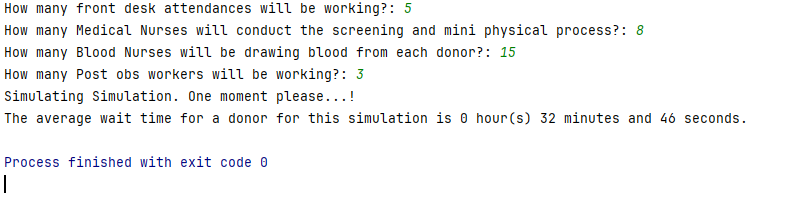

In [73]:
Image("screenshots/main_output.png")

# Appendix

## Generating blood drive donors 

In [81]:
from numpy.random import default_rng
rg = default_rng(seed=4470)
print(rg.random())
print(rg.random())

0.45855804438027437
0.15021752731855942


In [83]:
def donor_rand_arrivals(env, interarrival_time=0, rg=default_rng(0)):
    """Generating blood donors according to a Poisson arrival process"""

    # Creation of counter to keep track of the number of donors generated and there unique id
    donor = 0

    # Infinite loop for generating donors
    while True:

        # Generate next interarrival time from exponential distribution
        iat = rg.exponential(mean_interarrival_time)
        
        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # update counter of donor
        donor += 1
        
        print(f"Donor {donor} created at time {env.now}")



In [91]:
# Initialize a simulation environment
env1 = simpy.Environment()

# Create a process generator and start it and add it to the env
# env.process() starts the patient_arrivals process and adds it to the environment
runtime = 100
interarrival_time = 5.0
env1.process(donor_rand_arrivals(env1, interarrival_time))

# Run the simulation
env1.run(until=runtime)

NameError: name 'mean_interarrival_time' is not defined

In [93]:
# Import exponential distribution function from scipy.stats
from scipy.stats import expon
# Set mean of this distribution to whatever we were using above for interarrival time
mean_interarrival_time = interarrival_time
# Create a random variable object based on the exponential distribution with the given mean
rv_expon = expon(scale=mean_interarrival_time)

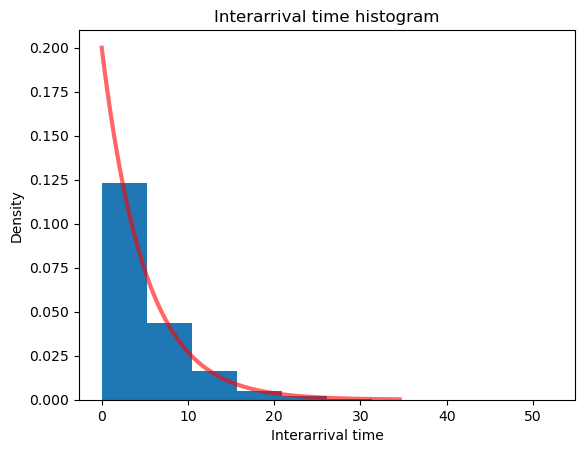

In [95]:
# Generate 1000 exponential random variates (notice this is the exponential function from numpy)
iat_sample = rg.exponential(mean_interarrival_time, 10000)

# Create a histogram of the random samples with exponential pdf overlaid
plt.title("Interarrival time histogram")
plt.xlabel("Interarrival time")
plt.ylabel("Density")
plt.hist(iat_sample, density=True);

# Create values for the x-axis using expon function from SciPy
x_expon = np.linspace(rv_expon.ppf(0.0001),
                rv_expon.ppf(0.999), 500)

# Create values for the y-axis
y_expon_pdf = rv_expon.pdf(x_expon)

plt.plot(x_expon, y_expon_pdf,
       'r-', lw=3, alpha=0.6, label='Exponential pdf');

